# [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

## [Abstract](#abstract)

The Traveling Salesman Problem (TSP) is a **classic problem in [combinatorial optimization](https://en.wikipedia.org/wiki/Combinatorial_optimization)**.

It is the problem of **finding a tour of minimum cost that visits each city exactly once**. The TSP is **NP-hard**. That is, no efficient algorithm is known that finds the optimal solution to the problem for large sets of cities.

## [Exhaustive](#exhaustive-search)
It is a **brute force** algorithm that does not use any information about the problem to find the solution.

- [Heap's Algorithm](#heaps-algorithm)
- [Steinhaus–Johnson–Trotter Algorithm](#sjt-algorithm)

## [Random](#random-search)
Is a **[stochastic optimization](https://en.wikipedia.org/wiki/Stochastic_optimization)** algorithm that does not use any information about the problem to find the solution.

## [Hill Climbing](#hill-climbing-search)
Is a **[local search](https://en.wikipedia.org/wiki/Local_search_(optimization))** algorithm that does not use any information about the problem to find the solution.

----

### Abstract

In this notebook, we're exploring various techniques to solve the [Traveling Salesman Problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Our focus is on implementing **exhaustive search**, **random search**, and **hill-climbing algorithms** to tackle this problem. Additionally, **we'll visualize the results of each iteration**, **analyze their performance**, and **draw insightful conclusions**.

By delving into these algorithms and their outcomes, we aim to enhance our understanding of optimization techniques and their practical applications.

In [1]:
import random
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# constants
CITIES = 7  # number of cities
GENERATIONS = 100  # number of generations to run
MUTATION_RATE = 0.01  # mutation rate (0.01 = 1%) 1/100

In these part I've define some functions to help us to manage all the algorithms and to visualize the results.

In [2]:
def generate_cities(cities: int) -> np.ndarray:
    """Generate cities with random x and y coordinates."""
    return np.random.rand(cities, 2)


def get_distance_between_cities(city1: np.ndarray, city2: np.ndarray) -> float:
    """Get distance between two cities."""
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)


def plot_solution(title: str, cities: np.ndarray, solution: np.ndarray) -> None:
    """Plot solution."""
    plt.figure(figsize=(12, 12))
    [plt.plot([cities[solution[i]][0], cities[solution[i + 1]][0]], [cities[solution[i]][1], cities[solution[i + 1]][1]], c='blue') for i in range(CITIES - 1)]
    # plt.plot([cities[solution[-1]][0], cities[solution[0]][0]], [cities[solution[-1]][1], cities[solution[0]][1]], c='blue')  # plot a line between the last and the first city
    plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)
    plt.title(title)
    plt.show()


def get_fitness(cities: np.ndarray, solution) -> float:
    """
    Get fitness of a solution.
    The fitness is the inverse of the total distance between cities (except the last and the first one)
    """
    distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)]
    return 1 / sum(distances)  # return fitness


def print_distances(cities: np.ndarray, solution: np.ndarray) -> None:
    """Print distances between cities according to the order in the solution."""
    # distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)] + [get_distance_between_cities(cities[solution[-1]], cities[solution[0]])]
    distances = [get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)]
    print(f"Solution:  {solution}\nDistance: {sum(distances)}")  # print solution and total distance
    [print(f"{solution[i-1]} -> {solution[i]}: {distances[i]}") for i in range(CITIES - 1)]  # print distances between cities


def crossover(parents: np.ndarray) -> np.ndarray:
    """Crossover parents to produce offspring."""
    return np.concatenate((parents[0][:CITIES // 2], [city for city in parents[1] if city not in parents[0][:CITIES // 2]]))


def mutate(offspring: np.ndarray) -> np.ndarray:
    """
    Mutate offspring.
    Shuffle offspring (mutation) if mutation rate is reached.
    """
    if np.random.rand() < MUTATION_RATE:  # if mutation rate is reached
        offspring = np.random.permutation(offspring)  # shuffle offspring (mutation)
    return offspring  # return offspring


[[0.66252035 0.80379931]
 [0.41780321 0.45272831]
 [0.46888982 0.43424359]
 [0.30819362 0.83682021]
 [0.05722727 0.2973984 ]
 [0.97636554 0.57873505]
 [0.49350589 0.11138968]]


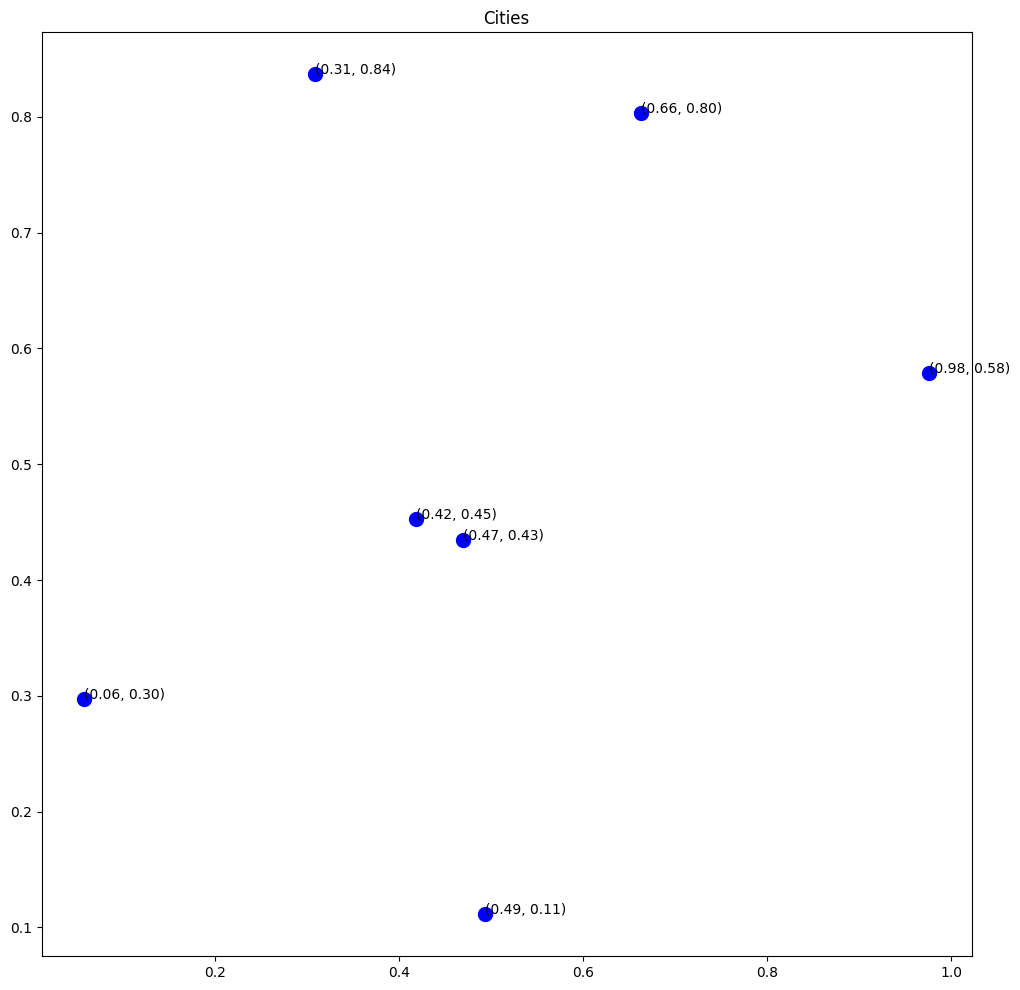

In [3]:
cities = generate_cities(CITIES)  # generate cities
# cities = np.array([[np.cos(2 * np.pi * i / CITIES), np.sin(2 * np.pi * i / CITIES)] for i in range(CITIES)])
print(cities)

# draw the circle
plt.figure(figsize=(12, 12))
# plt.plot(np.cos(2 * np.pi * np.linspace(0, 1, 100)), np.sin(2 * np.pi * np.linspace(0, 1, 100)), c='gray')  # draw the circle
plt.scatter(cities[:, 0], cities[:, 1], c='blue', s=100)  # draw the cities
[plt.annotate(f"({city[0]:.2f}, {city[1]:.2f})", (city[0], city[1]), fontsize=10) for _, city in enumerate(cities)]  # add the coordinates to the cities
plt.title("Cities")
plt.show()

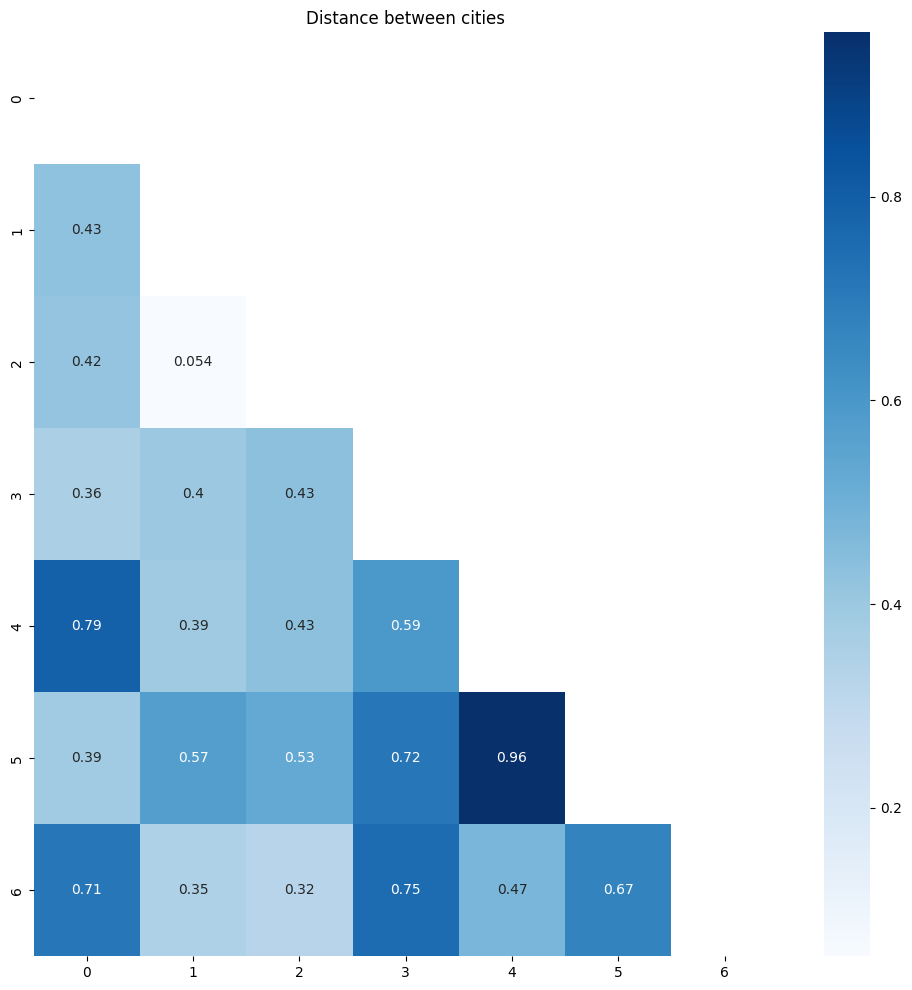

In [4]:
distances = np.zeros((CITIES, CITIES))
for i in range(CITIES):
    for j in range(CITIES):  
        distances[i, j] = get_distance_between_cities(cities[i], cities[j])

# plot the distance between cities (using heatmap)
plt.figure(figsize=(12, 12))
mask = np.zeros_like(distances)  # create a mask
mask[np.triu_indices_from(mask)] = True  # apply the mask
sns.heatmap(distances, annot=True, mask=mask, cmap='Blues')  # plot heatmap
plt.title('Distance between cities')
plt.show()

### [Exhaustive Search](https://en.wikipedia.org/wiki/Exhaustive_search)

We implement a program that generates all possible solutions for the TSP using two algorithms, namely the **Heap algorithm** and the **Steinhaus–Johnson–Trotter algorithm**. By examining the complete solution space, we aim to evaluate the computational feasibility of exhaustively solving TSP for a given number of cities.

- Time Complexity: $O(n!)$
- Space Complexity: $O(n)$

In [5]:
def exhaustive_search(cities: np.ndarray) -> tuple[np.ndarray, list[float]]:
    """Exhaustive search algorithm."""
    best_solution: np.ndarray = np.arange(CITIES)
    best_fitness = get_fitness(cities, best_solution)

    all_fitnesses = []

    for solution in itertools.permutations(np.arange(CITIES)):
        fitness = get_fitness(cities, solution)
        all_fitnesses.append(fitness)
        if fitness > best_fitness:  # if new best solution is found
            print(f"New best solution found: {solution} with fitness {fitness}")
            best_fitness = fitness  # update best fitness
            best_solution = solution  # type: ignore # update best solution
    return (best_solution, all_fitnesses)  # return best solution

exhaustive_solution = exhaustive_search(cities)  # run exhaustive search

print(exhaustive_solution)

New best solution found: (0, 1, 2, 3, 4, 6, 5) with fitness 0.37637203591309254
New best solution found: (0, 1, 2, 6, 4, 3, 5) with fitness 0.3858665428474473
New best solution found: (0, 3, 1, 2, 4, 6, 5) with fitness 0.4184643180791624
New best solution found: (0, 3, 2, 1, 4, 6, 5) with fitness 0.4197225136522423
New best solution found: (0, 3, 4, 6, 1, 2, 5) with fitness 0.4243239979801521
New best solution found: (0, 5, 3, 1, 2, 6, 4) with fitness 0.4247533764625899
New best solution found: (1, 2, 6, 4, 3, 0, 5) with fitness 0.4567449058287713
New best solution found: (3, 0, 5, 1, 2, 6, 4) with fitness 0.4614547954671371
New best solution found: (3, 0, 5, 2, 1, 6, 4) with fitness 0.4655607737452386
New best solution found: (4, 6, 1, 2, 3, 0, 5) with fitness 0.4869103072038507
New best solution found: (4, 6, 2, 1, 3, 0, 5) with fitness 0.501533137445513
((4, 6, 2, 1, 3, 0, 5), [0.31807625660888905, 0.37637203591309254, 0.32599532502429956, 0.3599344851947744, 0.3225836559494045, 0.3

Solution:  (4, 6, 2, 1, 3, 0, 5)
Distance: 1.9938861968191302
5 -> 4: 0.4742765841605126
4 -> 6: 0.3237909802395311
6 -> 2: 0.054327950333862195
2 -> 1: 0.3994256585657073
1 -> 3: 0.35586206894935085
3 -> 0: 0.3862029545701663


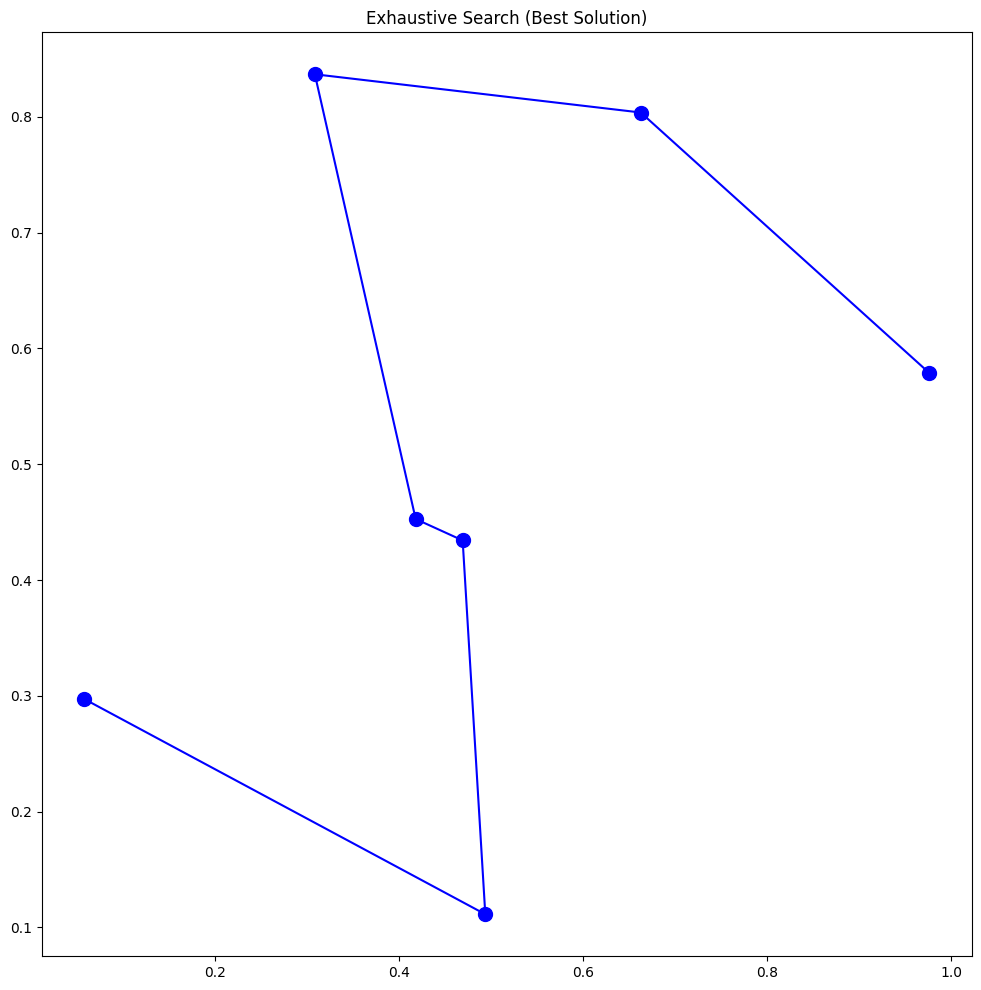

In [6]:
print_distances(cities, exhaustive_solution[0])  # print distances
plot_solution("Exhaustive Search (Best Solution)", cities, exhaustive_solution[0])  # plot solution

#### [Heap's Algorithm](https://en.wikipedia.org/wiki/Heap%27s_algorithm)

The Heap's Algorithm constructs all possible permutations of $n$ objects. It is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [B. R. Heap](https://en.wikipedia.org/wiki/B._R._Heap), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

See also the [original paper](https://watermark.silverchair.com/6-3-293.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAsIwggK-BgkqhkiG9w0BBwagggKvMIICqwIBADCCAqQGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM2W6w8Xqw0-17kz6lAgEQgIICdfPrsgBP0Cgc2wbMXjRGZhPqXfo5Z4GsCedCurL8Y4XuYwb7PVR1rdZ7TZhm-vkY5k9MU2Q90HgAIrxFG6Yt8cSVjC9rbnFPTDs5DHqHHSdxk9FrWBAdQQNovxrOcaXDJR3vFGUNhfiYDFlt1lAyOYLgGVsS83R74vj9Bm9QLX_tT_INwtbwQGtzE59EH9621_iMnDmkmMqZsKiOyclGHqMaROeVJs_-WUrW3oGE5BvjeM52Zs1k4Xe6pPVIsHhRg3Af00RYSRr3Q74ti0jvhewdseR73sJtsypApAb4YNsOxN4-Vk60L82GXMjAdDo2_CtRMnYXIWr_RwmWspFhsUXnHmwahS_uunBvfTm-76EhPOn0h8Sqjnf8baWfmDDNFf4xSr1o7F1Fxj6f6iyxZp3b0dAlMhxqhVS5PIwHtZwQXMejDUBK5X-Wh2ZxV7UH-zDK-H6rSFppNnssxJxz2TIZ7xQpdPbD6l64BnFRBWkogS2bbZ6m_z-blyjEeeKblNGr8HPT6kw7sEj6_4I7OKtKW54REcR5SFhWibWK1_QQkl-ammMyjSm7P4HMqjJVuifYL2rnKPVYtyT73r2buCbeVB6t6wG1iloyOq-0cPumL8su53hkqq7_5VlkMmoRM4pAIN2NIV27eYymLMgmx9Ku1wEgP0q9JHE-11T_TqxZGuHt5f9-R6JtFD-Ms9qkAoQOoSJFp88-5zeJWTa2wU4jokIrh_QwJVcPT39xR7Q5Qb1pXQLFzZ9d80RVioVfiePH98l81o6yW-BqHW2Q0rSfCLuoYSoru4Im06m_1C-jc9r9UCXS5SsYb_it5A5BCD4Z2Ylv) pdf. 

In [7]:
def heap_permutations(cities: np.ndarray, size: int) -> np.ndarray:
    permutations = []  # List to store permutations

    # Auxiliar function to generate all permutations of a list
    def generate_permutations(cities: np.ndarray, n: int) -> None:
        if n != 1:  # if size is not 1 then generate all permutations of size n-1
            for i in range(n):  # One by one move all characters from first to last
                generate_permutations(cities, n - 1)  # call generate_permutations() recursively to generate the permutations
                if n % 2 == 0: cities[i], cities[n - 1] = cities[n - 1], cities[i]   # if n is even swap ith and last element
                else: cities[0], cities[n - 1] = cities[n - 1], cities[0]  # If n is odd swap first and last element
        else: permutations.append(cities.copy())  # If size is 1 then append the obtained permutation

    generate_permutations(cities.copy(), size)  # Generate all permutations of cities
    return np.array(permutations)  # Return permutations as a numpy array

solution = np.arange(CITIES)
permutations = heap_permutations(cities, len(solution))

In [8]:
# print_distances(cities, heap_solution)
# plot_solution("Heap's Algorithm (A good solution)", cities, heap_solution)

#### [SJT Algorithm](https://en.wikipedia.org/wiki/Steinhaus%E2%80%93Johnson%E2%80%93Trotter_algorithm)

The Steinhaus-Johnson-Trotter (SJT) algorithm is a **[recursive](https://en.wikipedia.org/wiki/Recursion_(computer_science))** algorithm that generates each permutation from the previous one by choosing two elements to interchange.

The algorithm generates each permutation from the previous one by choosing two elements to interchange. The number of permutations of $n$ objects is $n!$.

The algorithm is named after [Hugo Steinhaus](https://en.wikipedia.org/wiki/Hugo_Steinhaus), [Selmer M. Johnson](https://en.wikipedia.org/wiki/Selmer_M._Johnson), and [Hale F. Trotter](https://en.wikipedia.org/wiki/Hale_F._Trotter), who published it in 1963, but it was first proposed by [Johnson](https://en.wikipedia.org/wiki/Johnson%27s_algorithm) in 1962.

In [9]:
LEFT_TO_RIGHT = True  # LEFT TO RIGHT direction
RIGHT_TO_LEFT = False  # RIGHT TO LEFT direction

# Utility functions for finding the position of largest mobile integer in a[].
def searchArr(a, n, mobile) -> int: # type: ignore
	for i in range(n):
		if a[i] == mobile:
			return i + 1

# To carry out step 1 of the algorithm i.e. to find the largest mobile integer.
def getMobile(a, dir, n):
	mobile_prev = 0
	mobile = 0
	for i in range(n):
		# direction 0 represents RIGHT TO LEFT.
		if dir[a[i] - 1] == RIGHT_TO_LEFT and i != 0:
			if a[i] > a[i - 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
		# direction 1 represents LEFT TO RIGHT.
		if dir[a[i] - 1] == LEFT_TO_RIGHT and i != n - 1:
			if a[i] > a[i + 1] and a[i] > mobile_prev:
				mobile = a[i]
				mobile_prev = mobile
	if mobile == 0 and mobile_prev == 0:
		return 0
	else:
		return mobile

# Prints a single permutation
def printOnePerm(a, dir, n):
	mobile = getMobile(a, dir, n)
	pos: int = searchArr(a, n, mobile)

	# swapping the elements according to the direction i.e. dir[]
	if dir[a[pos - 1] - 1] == RIGHT_TO_LEFT: a[pos - 1], a[pos - 2] = a[pos - 2], a[pos - 1]
	elif dir[a[pos - 1] - 1] == LEFT_TO_RIGHT: a[pos], a[pos - 1] = a[pos - 1], a[pos]
	for i in range(n):  # changing the directions for elements greater than largest mobile integer
		if a[i] > mobile:
			if dir[a[i] - 1] == LEFT_TO_RIGHT: dir[a[i] - 1] = RIGHT_TO_LEFT
			elif dir[a[i] - 1] == RIGHT_TO_LEFT: dir[a[i] - 1] = LEFT_TO_RIGHT
	for i in range(n): print(a[i], end='')
	print("")

# To end the algorithm for efficiency it ends at the factorial of n because number of permutations possible is just n!.
def fact(n):
	res = 1
	for i in range(1, n + 1): res = res * i
	return res

# This function mainly calls printOnePerm() one by one to print all permutations.
def printPermutation(n):
	# To store current permutation storing the elements from 1 to n and
	a = [i + 1 for i in range(n)]

	# Printing the first permutation
	for i in range(n): print(a[i], end='')
	print("")
	# To store current directions initially all directions are set to RIGHT TO LEFT i.e. 0.
	dir = [RIGHT_TO_LEFT for i in range(n)]
	# for generating permutations in the order.
	for i in range(1, fact(n)): printOnePerm(a, dir, n)

# Driver code
n = 4
printPermutation(n)

1234
1243
1423
4123
4132
1432
1342
1324
3124
3142
3412
4312
4321
3421
3241
3214
2314
2341
2431
4231
4213
2413
2143
2134


### [Random Search](https://en.wikipedia.org/wiki/Random_search)

Random Search is a simple **[stochastic](https://en.wikipedia.org/wiki/Stochastic)** optimization algorithm that does not use any information about the problem to find the solution. It is a **[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method)** method that randomly samples the search space to find the solution.

In [10]:
def random_search(cities: np.ndarray, iterations: int = 100) -> np.ndarray:
    """
    Random Search Algorithm is a simple one. Just generate a random solution and check if it is better than the best solution found so far.
    If it is, then update the best solution. Repeat this process for a given number of iterations.

    ### Parameters:
        cities: np.ndarray - The cities to visit.
        iterations: int - The number of iterations to run the algorithm for.

    ### Returns:
        np.ndarray - The best solution found.
    """
    best_fitness = np.inf
    best_solution = np.arange(CITIES)
    for _ in range(iterations):  # for each iteration
        solution = np.random.permutation(CITIES)
        fitness = np.sum([get_distance_between_cities(cities[solution[i]], cities[solution[i + 1]]) for i in range(CITIES - 1)])
        if fitness < best_fitness:
            print(f"New best solution found: {solution} with fitness {fitness}")
            best_fitness = fitness
            best_solution = solution  # update best solution
    return best_solution  # return best solution

random_solution = random_search(cities, 10)  # just run for 10 iterations (for the sake of time)

New best solution found: [6 4 2 3 0 5 1] with fitness 2.656216547425796
New best solution found: [4 3 5 0 2 1 6] with fitness 2.5186021340588747


Solution:  [4 3 5 0 2 1 6]
Distance: 2.5186021340588747
6 -> 4: 0.5949453801015572
4 -> 3: 0.716283231210331
3 -> 5: 0.3862029545701663
5 -> 0: 0.4172100241716013
0 -> 2: 0.054327950333862195
2 -> 1: 0.34963259367135685


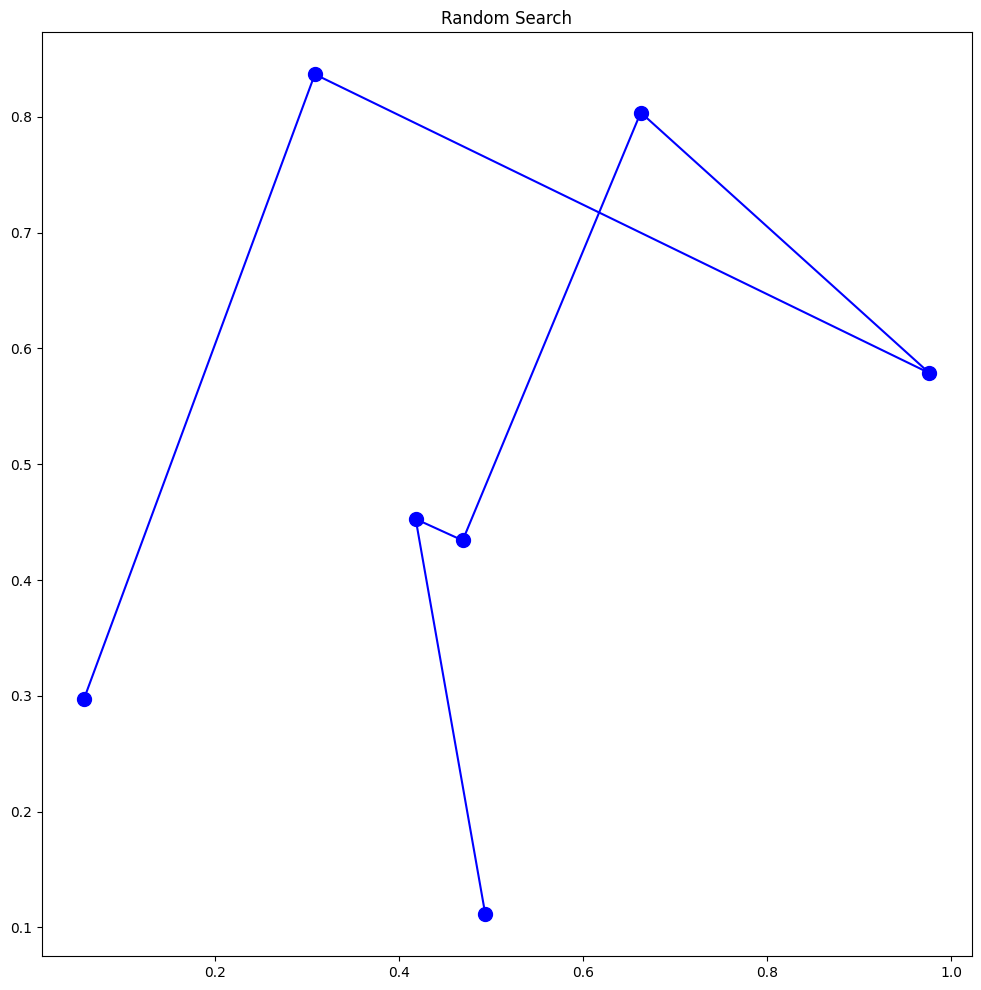

In [11]:
print_distances(cities, random_solution)
plot_solution("Random Search", cities, random_solution)

### [Hill Climbing Search](https://en.wikipedia.org/wiki/Hill_climbing)

In [12]:
#calculate the path based on the random solution
def path_length(matrix, solution):
    cycle_length = 0
    for i in range(0, len(solution)):
        cycle_length += matrix[solution[i]][solution[i - 1]]
    return cycle_length
 
#generate neighbors of the random solution by swapping cities and returns the best neighbor
def neighbors(matrix, solution):
    neighbors = []
    for i in range(len(solution)):
        for j in range(i + 1, len(solution)):
            neighbor = solution.copy()
            neighbor[i] = solution[j]
            neighbor[j] = solution[i]
            neighbors.append(neighbor)
             
    #assume that the first neighbor in the list is the best neighbor      
    best_neighbor = neighbors[0]
    best_path = path_length(matrix, best_neighbor)
     
    #check if there is a better neighbor
    for neighbor in neighbors:
        current_path = path_length(matrix, neighbor)
        if current_path < best_path:
            best_path = current_path
            best_neighbor = neighbor
    return best_neighbor, best_path

 
def hill_climbing(coordinate):
    matrix = []  # generate matrix
    for i in range(len(coordinate)):  # calculate the distance between each city
        for j in range(len(coordinate)):  # and add it to the matrix
            p = np.linalg.norm(coordinate[i] - coordinate[j])  # calculate the distance between city i and city j
            matrix.append(p)  # add the distance to the matrix
    matrix = np.reshape(matrix, (len(coordinate),len(coordinate)))  # reshape the matrix to be 2D

    current_solution = np.random.permutation(len(coordinate))  # generate a random solution
    current_path = path_length(matrix, current_solution)
    neighbor = neighbors(matrix,current_solution)[0]
    best_neighbor, best_neighbor_path = neighbors(matrix, neighbor)
 
    while best_neighbor_path < current_path:
        current_solution = best_neighbor
        current_path = best_neighbor_path
        neighbor = neighbors(matrix, current_solution)[0]
        best_neighbor, best_neighbor_path = neighbors(matrix, neighbor)
 
    return np.array(current_solution)

hill_climbing_solution = hill_climbing(cities)

Solution:  [1 6 4 3 0 5 2]
Distance: 2.6885647148351737
2 -> 1: 0.34963259367135685
1 -> 6: 0.4742765841605126
6 -> 4: 0.5949453801015572
4 -> 3: 0.35586206894935085
3 -> 0: 0.3862029545701663
0 -> 5: 0.5276451333822298


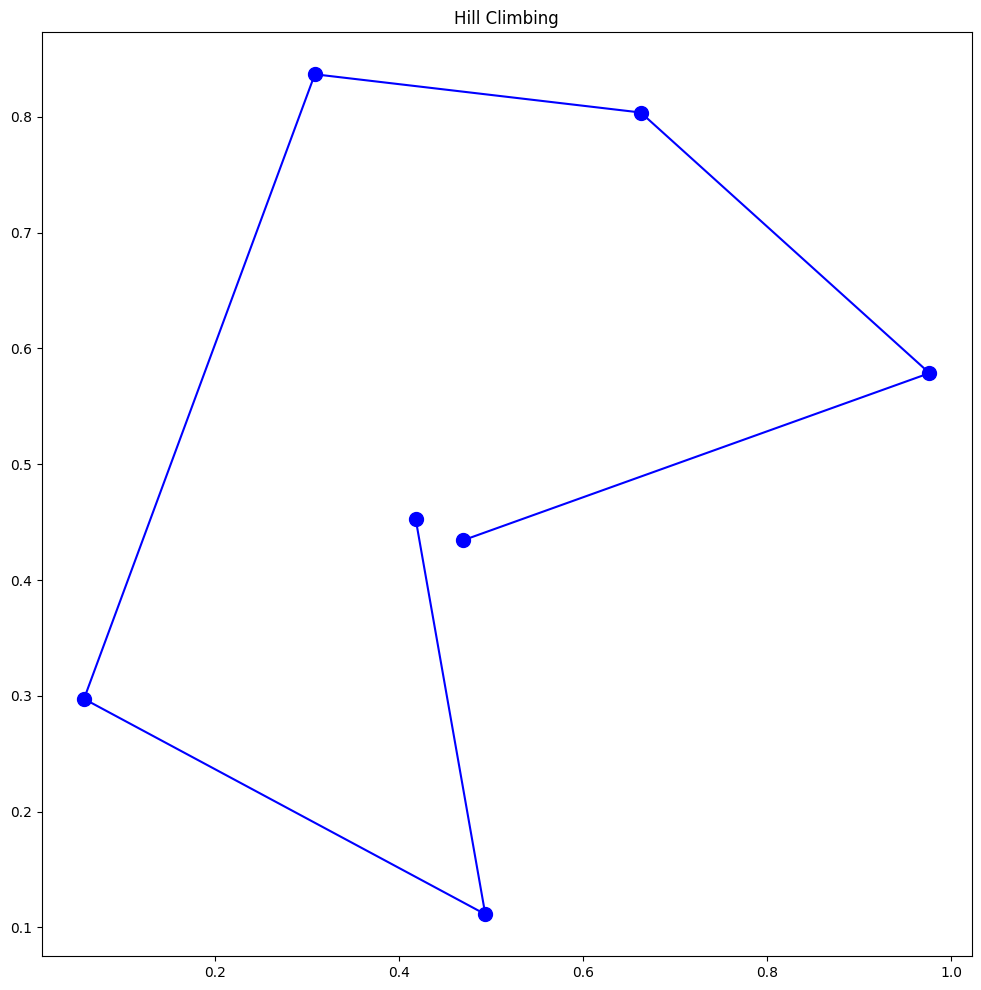

In [13]:
print_distances(cities, hill_climbing_solution)
plot_solution("Hill Climbing", cities, hill_climbing_solution)

### Comparison

In [14]:
# plot_solution("Exhaustive Search", cities, exhaustive_solution)
# plot_solution("Heaps Algorithm", cities, heaps_solution)
# plot_solution("SJT Algorithm", cities, sjt_solution)
# plot_solution("Random Search", cities, random_solution)
# plot_solution("Hill Climbing", cities, hill_climbing_solution)

# use sns to plot all the solutions on the same graph
# sns.scatterplot(x="x", y="y", data=pd.DataFrame(cities, columns=["x", "y"]), color="blue")

# plt.show()